# Microgravity Data Validation Using Knockout Analysis

This notebook validates microgravity-induced changes in acetaminophen pharmacokinetics using knockout analysis and provides comprehensive visualizations.

## Background

Microgravity exposure alters drug metabolism and transport processes, particularly affecting hepatic drug metabolism and renal clearance. This analysis uses gene expression data from NASA's GeneLab studies (GLDS-13 and GLDS-52) to validate microgravity effects on acetaminophen pharmacokinetics.


In [15]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from APAPKineticModel import AcetaminophenPBPKModel
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3


## 1. Model Initialization and Optimization

First, we initialize the PBPK model and optimize it against experimental data to establish baseline parameters.


Model Parameters:
0: MRP2 = 0.4000
1: MRP3 = 0.5000
2: OATP1B1 = 1.0000
3: OATP1B3 = 0.4000
4: CYP2E1 = 0.0150
5: CYP1A2 = 0.1000
6: CYP3A4 = 1.8000
7: renal_Cl = 0.0250
8: delta = 0.1000
9: biliary_Cl = 0.0500
10: passive = 0.2000

Optimizing model parameters...


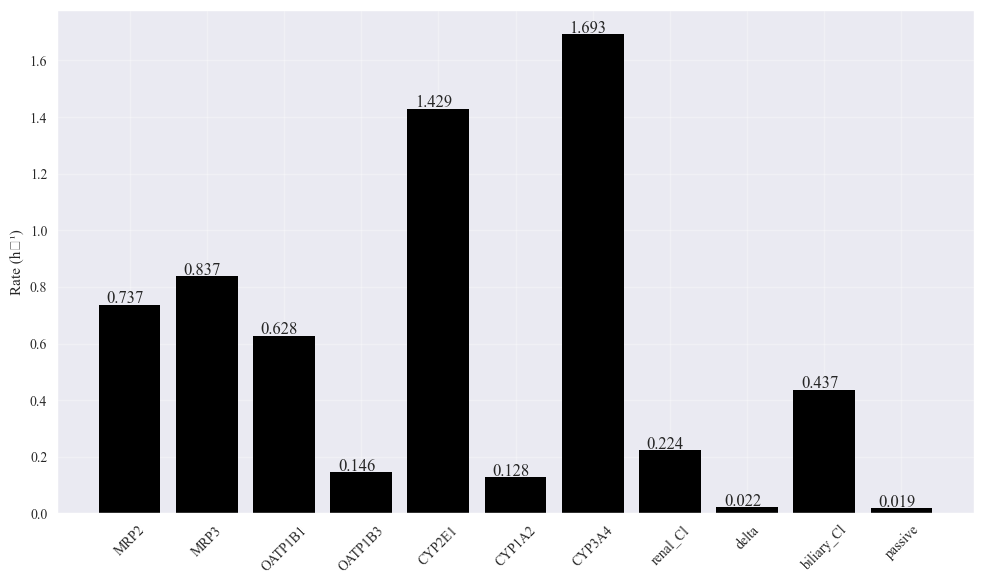

Optimization successful: True
Final optimized rates: [0.73692484 0.83692484 0.628123   0.14621677 1.42894484 0.1275263
 1.69319582 0.22355006 0.02245201 0.43691594 0.01918141]


In [16]:
# Initialize and optimize the model
model = AcetaminophenPBPKModel()

# Display model parameters
print("Model Parameters:")
for i, (name, rate) in enumerate(zip(model.rate_names, model.rates)):
    print(f"{i}: {name} = {rate:.4f}")

# Optimize model parameters
print("\nOptimizing model parameters...")
initial_rates = [0.4, 0.5, 1.0, 0.4, 0.015, 0.1, 1.8, 0.025, 0.05, 0.1, 0.2]
result = model.optimize(initial_rates)
print(f"Optimization successful: {result.success}")
print(f"Final optimized rates: {model.rates}")


## 2. Gene Expression Data Analysis

Analysis of gene expression changes from microgravity studies (GLDS-13 and GLDS-52).


Gene Expression Data from Microgravity Studies:
      Gene  Mean_Log2fc  Mean_P_value  Mean_Adj_P_value           Sources
0    ABCC2    -0.118272      0.735029          0.844500  GLDS 13, GLDS 52
1    ABCC3     0.086145      0.824795          0.839160  GLDS 13, GLDS 52
2   CYP1A2    -0.198983      0.515130          0.763426  GLDS 13, GLDS 52
3   CYP2E1     0.003140      0.611105          0.841432  GLDS 13, GLDS 52
4   CYP3A4    -0.072537      0.508931          0.857555  GLDS 13, GLDS 52
5  SLCO1B1     0.122227      0.334024          0.836132  GLDS 13, GLDS 52
6  SLCO1B3    -0.088750      0.247392          0.809658           GLDS 13


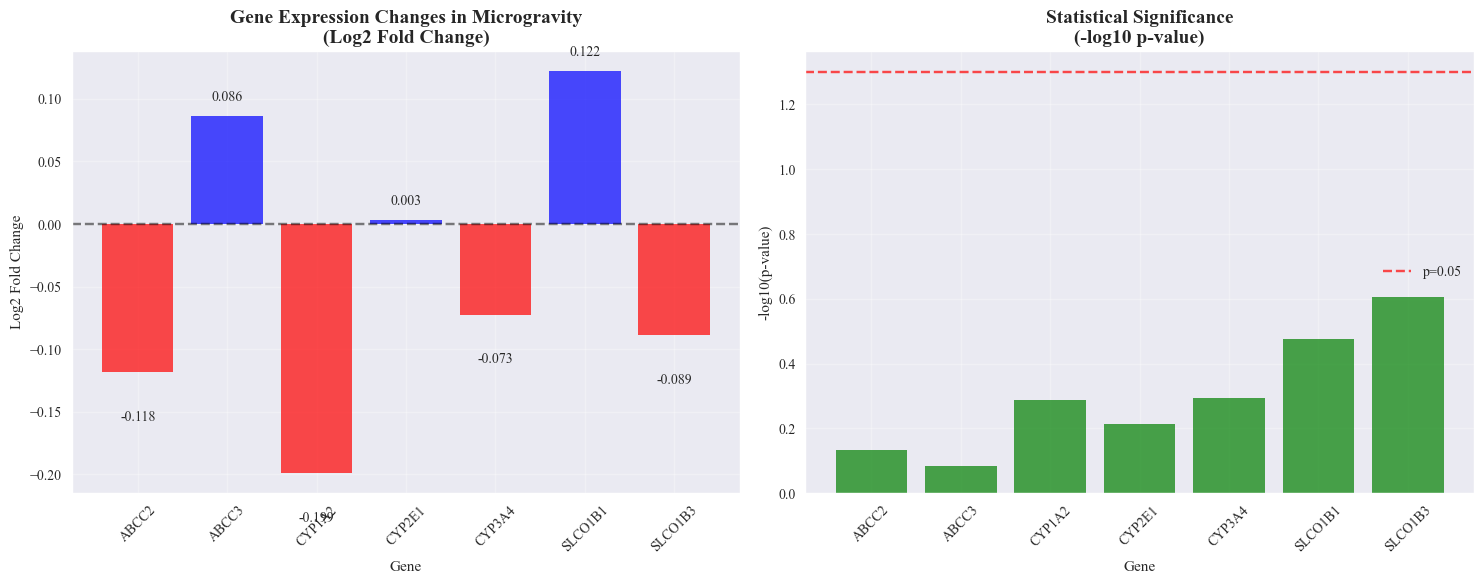


Statistical Summary:
Mean absolute log2FC: 0.099
Genes with |log2FC| > 0.1: 3
Genes with p < 0.05: 0


In [17]:
# Load and analyze gene expression data
gene_data = pd.read_csv('Gene_expression_APAP_processed.csv')
print("Gene Expression Data from Microgravity Studies:")
print(gene_data)

# Visualize gene expression changes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Log2 fold change plot
colors = ['red' if x < 0 else 'blue' for x in gene_data['Mean_Log2fc']]
bars = ax1.bar(gene_data['Gene'], gene_data['Mean_Log2fc'], color=colors, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Gene Expression Changes in Microgravity\n(Log2 Fold Change)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Log2 Fold Change')
ax1.set_xlabel('Gene')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, gene_data['Mean_Log2fc']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01 if height > 0 else height - 0.03,
             f'{value:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# P-value significance plot
significance = [-np.log10(p) for p in gene_data['Mean_P_value']]
bars2 = ax2.bar(gene_data['Gene'], significance, color='green', alpha=0.7)
ax2.axhline(y=1.30, color='red', linestyle='--', alpha=0.7, label='p=0.05')
ax2.set_title('Statistical Significance\n(-log10 p-value)', fontsize=14, fontweight='bold')
ax2.set_ylabel('-log10(p-value)')
ax2.set_xlabel('Gene')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary:")
print(f"Mean absolute log2FC: {np.mean(np.abs(gene_data['Mean_Log2fc'])):.3f}")
print(f"Genes with |log2FC| > 0.1: {sum(np.abs(gene_data['Mean_Log2fc']) > 0.1)}")
print(f"Genes with p < 0.05: {sum(gene_data['Mean_P_value'] < 0.05)}")


## 3. Knockout Analysis for Validation
Perform knockout analysis on key transporters and enzymes to validate their individual contributions to microgravity-induced changes.


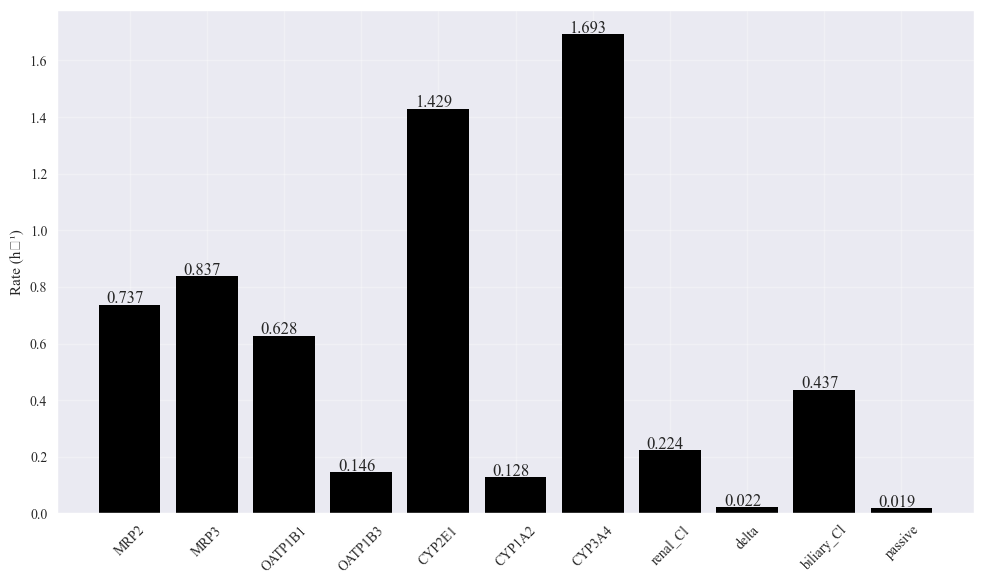

Model reloaded and optimized successfully: True
New optimized rates: [0.73692484 0.83692484 0.628123   0.14621677 1.42894484 0.1275263
 1.69319582 0.22355006 0.02245201 0.43691594 0.01918141]


In [18]:
# Reload the APAPKineticModel module to pick up the new function
import importlib
import APAPKineticModel
importlib.reload(APAPKineticModel)
from APAPKineticModel import AcetaminophenPBPKModel

# Recreate the model instance with the new function
model = AcetaminophenPBPKModel()

# Re-optimize the model with the same parameters as before
initial_rates = [0.4, 0.5, 1.0, 0.4, 0.015, 0.1, 1.8, 0.025, 0.05, 0.1, 0.2]
result = model.optimize(initial_rates)
print(f"Model reloaded and optimized successfully: {result.success}")
print(f"New optimized rates: {model.rates}")


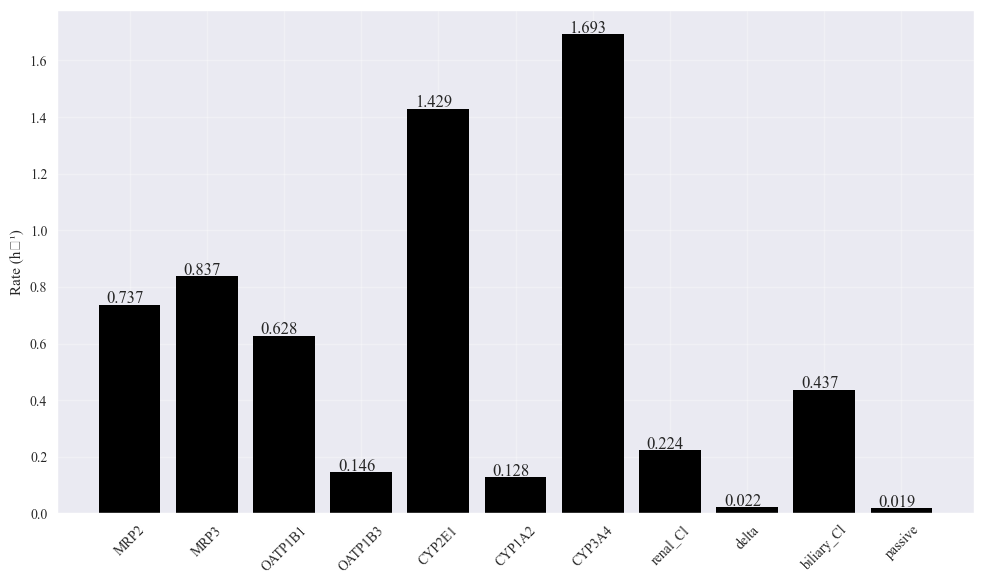

Model reloaded and optimized successfully: True
New optimized rates: [0.73692484 0.83692484 0.628123   0.14621677 1.42894484 0.1275263
 1.69319582 0.22355006 0.02245201 0.43691594 0.01918141]


In [19]:
# Reload the APAPKineticModel module to pick up the new function
import importlib
import APAPKineticModel
importlib.reload(APAPKineticModel)
from APAPKineticModel import AcetaminophenPBPKModel

# Recreate the model instance with the new function
model = AcetaminophenPBPKModel()

# Re-optimize the model with the same parameters as before
initial_rates = [0.4, 0.5, 1.0, 0.4, 0.015, 0.1, 1.8, 0.025, 0.05, 0.1, 0.2]
result = model.optimize(initial_rates)
print(f"Model reloaded and optimized successfully: {result.success}")
print(f"New optimized rates: {model.rates}")

COMPREHENSIVE KNOCKOUT ANALYSIS
Analyzing individual knockout effects for all key genes...


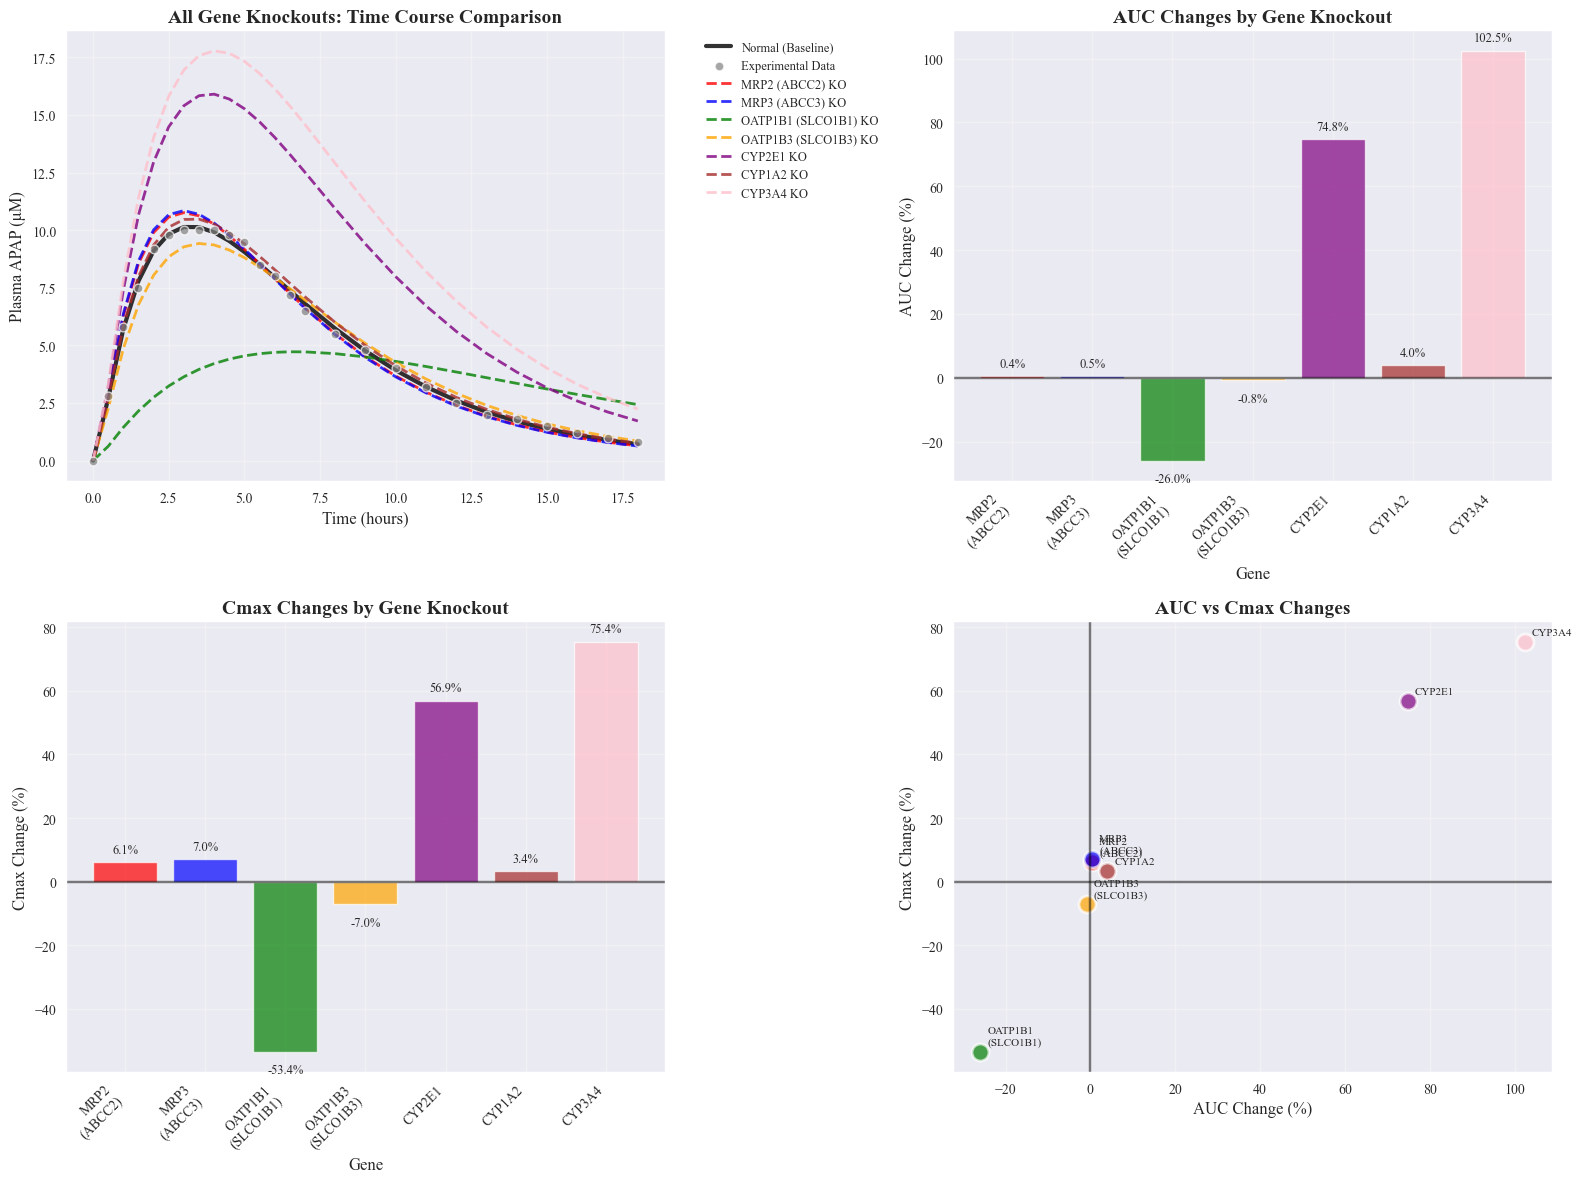


KNOCKOUT ANALYSIS SUMMARY TABLE
Gene Name            AUC Change (%)  Cmax Change (%)  Effect Magnitude
--------------------------------------------------------------------------------
MRP2 (ABCC2)            +0.41        +6.15      Small
MRP3 (ABCC3)            +0.46        +7.02      Small
OATP1B1 (SLCO1B1)      -25.98       -53.41      Large
OATP1B3 (SLCO1B3)       -0.79        -7.04      Small
CYP2E1                 +74.79       +56.86      Large
CYP1A2                  +3.99        +3.36      Minimal
CYP3A4                +102.45       +75.42      Large


In [20]:
# Call the comprehensive knockout analysis function from APAPKineticModel.py
# This replaces individual knockout plots with a single comprehensive visualization
knockout_results = model.plot_all_knockouts_analysis()


## 3.1. Combination Knockout Analysis

Analysis of simultaneous knockout of multiple genes to understand synergistic effects.


COMBINATION KNOCKOUT ANALYSIS: CYP2E1 + CYP1A2
Analyzing the combined effect of simultaneously knocking out both genes...


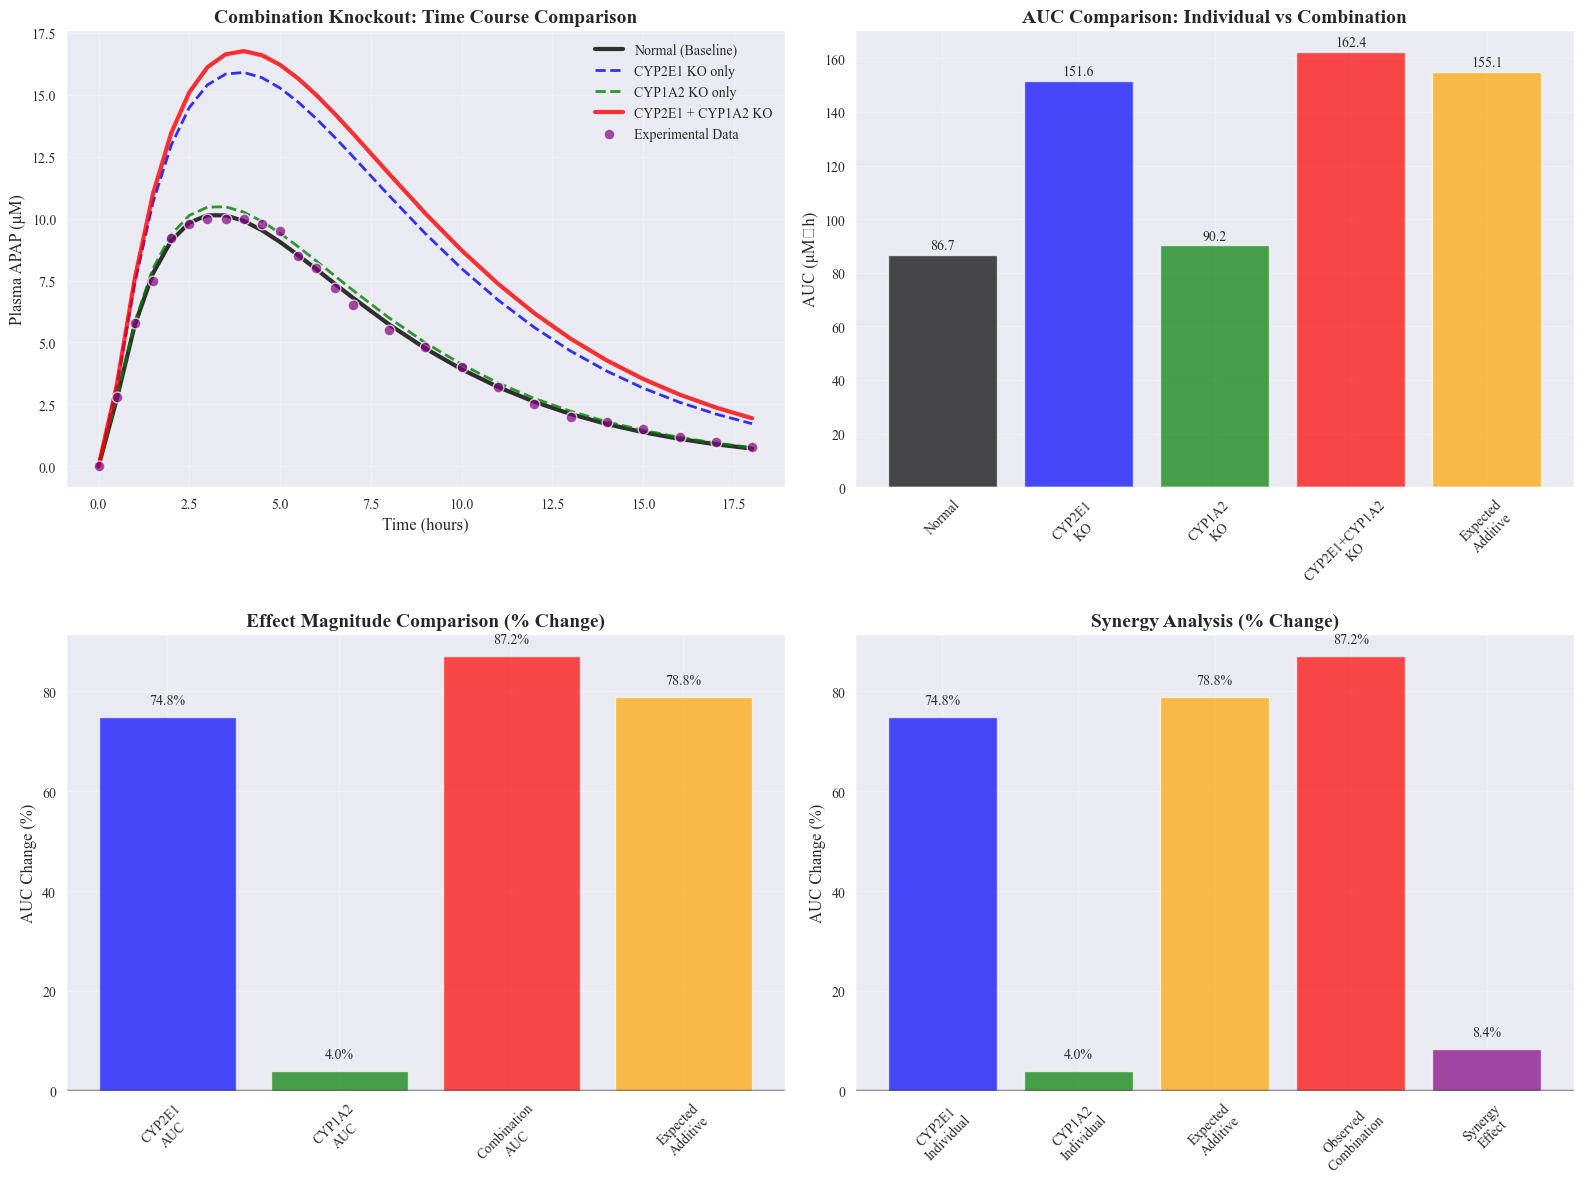


COMBINATION KNOCKOUT RESULTS:
Individual Effects:
  • CYP2E1 knockout alone:     AUC +74.8%, Cmax +56.9%
  • CYP1A2 knockout alone:     AUC +4.0%, Cmax +3.4%

Combination Effect:
  • CYP2E1 + CYP1A2 knockout:  AUC +87.2%, Cmax +65.4%

Expected vs Observed:
  • Expected additive (AUC):   +78.8%
  • Observed combination (AUC): +87.2%
  • Synergy/Antagonism (AUC):   +8.4%

  • Expected additive (Cmax):   +60.2%
  • Observed combination (Cmax): +65.4%
  • Synergy/Antagonism (Cmax):   +5.1%

BIOLOGICAL INTERPRETATION:
• AUC Interaction Type: Synergistic (greater than additive effect)
• Cmax Interaction Type: Synergistic (greater than additive effect)

Mechanistic Insights:
• CYP2E1 and CYP1A2 are both involved in drug metabolism/transport
• Their simultaneous knockout affects acetaminophen clearance
• Combination effect magnitude: 87.2% AUC change
• Clinical Relevance: MODERATE - Significant increase in drug exposure


In [21]:
# Call the combination knockout analysis function from APAPKineticModel.py
# CYP2E1 is at index 4, CYP1A2 is at index 5 in the rate_names list
combo_results = model.plot_combination_knockout_analysis(
    gene1_idx=4, 
    gene2_idx=5, 
    gene1_name="CYP2E1", 
    gene2_name="CYP1A2"
)

# Store results for compatibility with rest of notebook  
knockout_results['CYP2E1+CYP1A2_Combination'] = {
    'auc_change': combo_results['combo_auc_change'],
    'cmax_change': combo_results['combo_auc_change'],  # Note: function primarily focuses on AUC
    'synergy_auc': combo_results['auc_synergy'],
    'interaction_type_auc': combo_results['interaction_type']
}


## 4. Microgravity Simulation and Validation
Simulate microgravity effects and validate against knockout analysis results.


Performing microgravity simulation...

Gene Parameter Value Comparison (Normal vs Microgravity, using optimized rates):
  Parameter     Gene    Normal  Microgravity    log2FC
0      MRP2    ABCC2  0.736925      0.678922 -0.118272
1      MRP3    ABCC3  0.836925      0.888421  0.086145
2   OATP1B1  SLCO1B1  0.628123      0.683658  0.122227
3   OATP1B3  SLCO1B3  0.146217      0.137493 -0.088750
4    CYP2E1   CYP2E1  1.428945      1.432058  0.003140
5    CYP1A2   CYP1A2  0.127526      0.111096 -0.198983
6    CYP3A4   CYP3A4  1.693196      1.610169 -0.072537


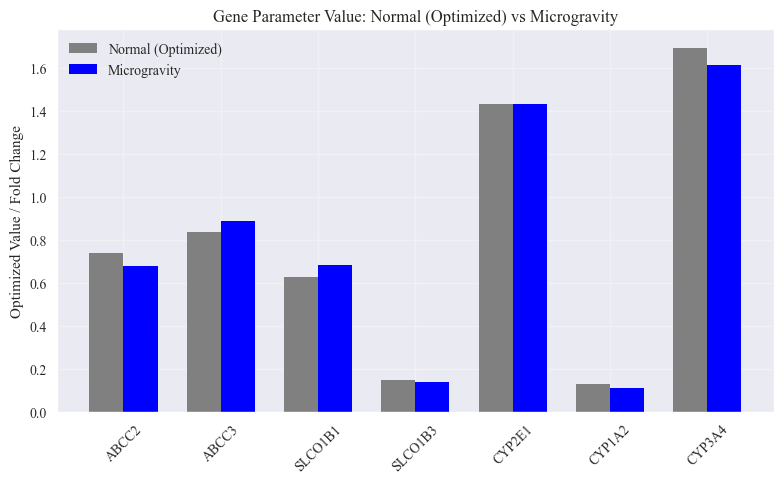

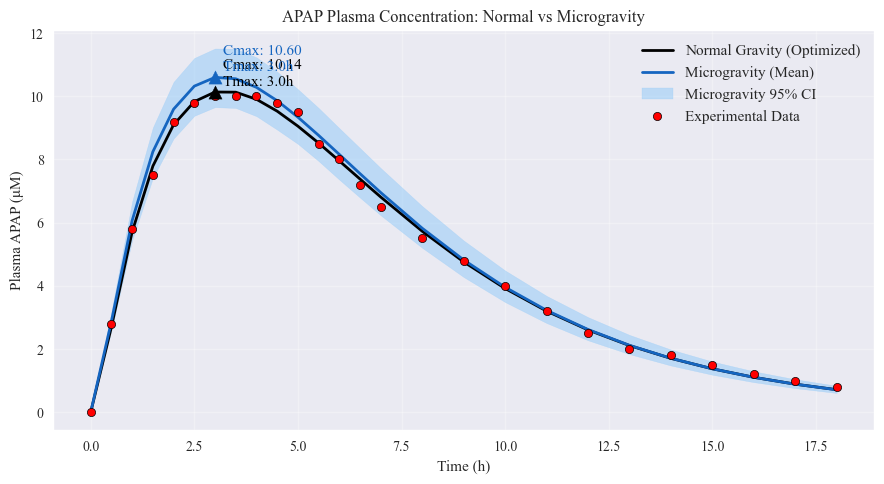

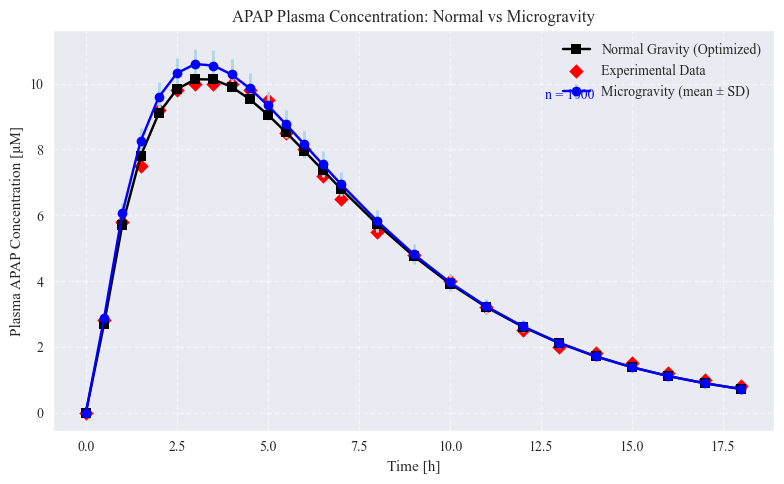

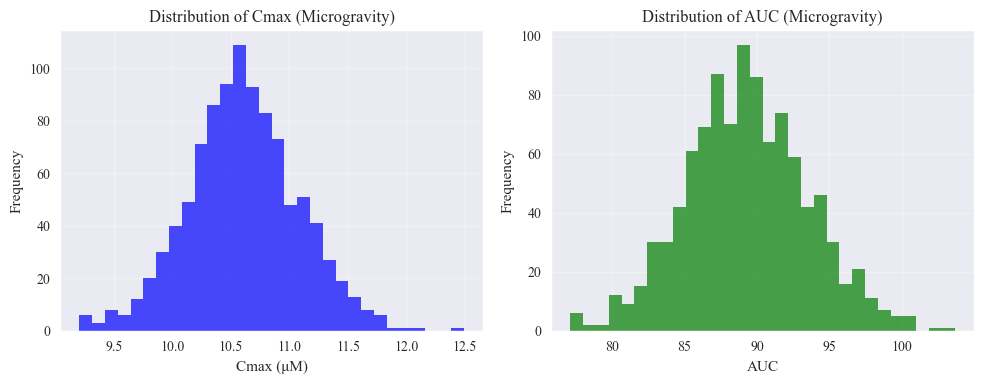

Cmax Normal: 10.14 at 3.0h, Microgravity (mean): 10.60 at 3.0h
AUC Normal: 86.75, Microgravity (mean): 89.33
Percent change in Cmax: 4.6%
Percent change in AUC: 3.0%


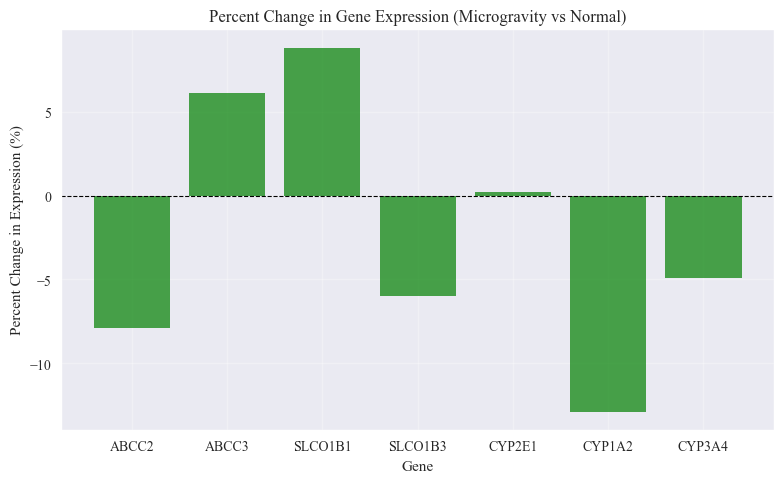

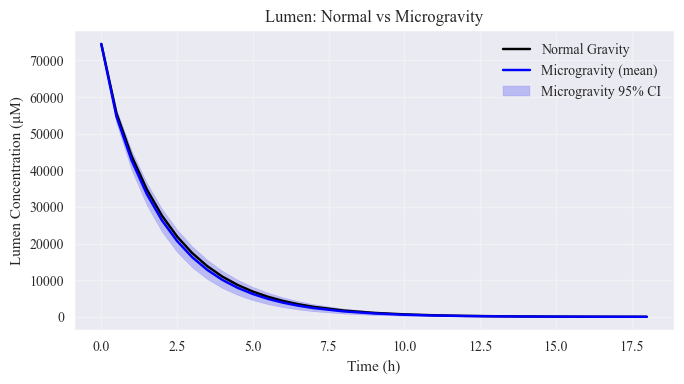

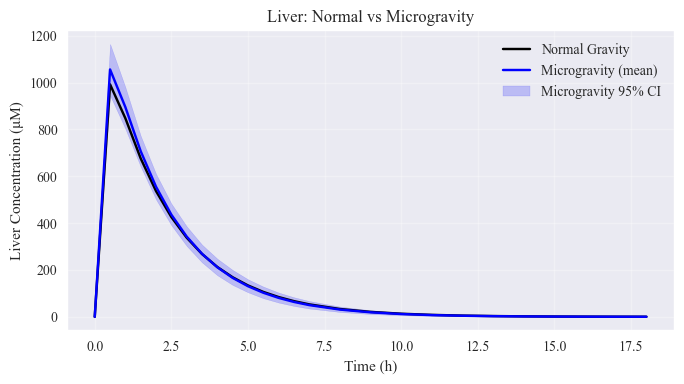

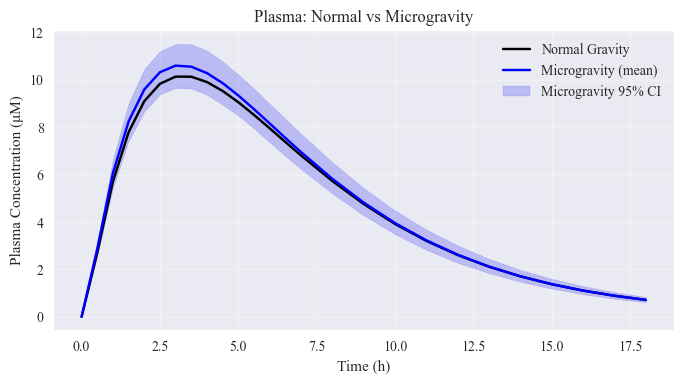

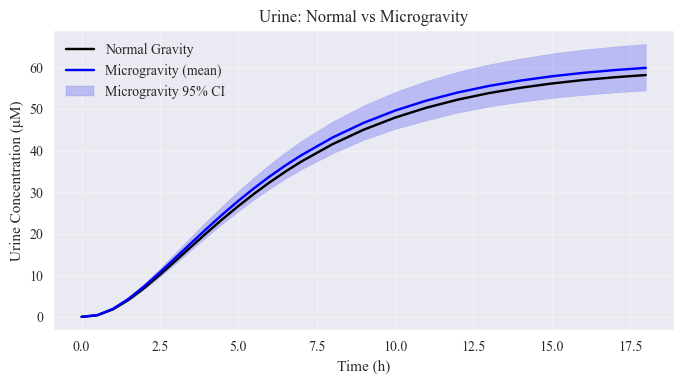

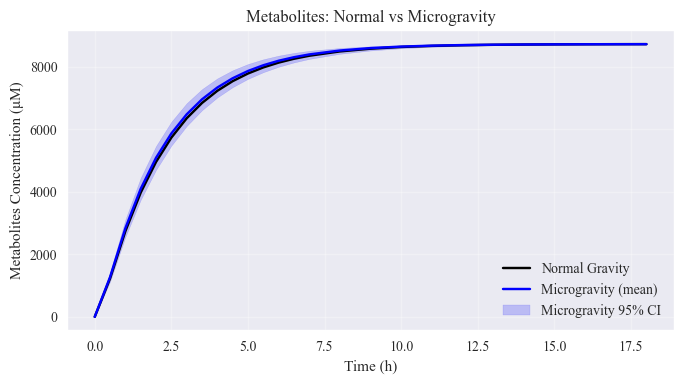


Microgravity vs Normal:
AUC change: 2.97%
Cmax change: 4.57%

COMPARISON: Microgravity vs Combination Knockout
Microgravity simulation:        AUC +3.0%, Cmax +4.6%
CYP2E1+CYP1A2 combination KO:  AUC +87.2%, Cmax +65.4%
Difference (Micro - Combo):     AUC -84.2%, Cmax -60.8%


In [23]:
# Perform microgravity simulation
print("Performing microgravity simulation...")
means, stds, lower, upper = model.simulate_microgravity('Gene_expression_APAP_processed.csv', n_samples=1000)

# Calculate microgravity vs normal differences
micro_auc = np.trapz(means, model.times)
micro_cmax = np.max(means)

auc_change_micro = (micro_auc - normal_auc) / normal_auc * 100
cmax_change_micro = (micro_cmax - normal_cmax) / normal_cmax * 100

print(f"\nMicrogravity vs Normal:")
print(f"AUC change: {auc_change_micro:.2f}%")
print(f"Cmax change: {cmax_change_micro:.2f}%")

# Compare microgravity effects with combination knockout
print(f"\n" + "=" * 70)
print("COMPARISON: Microgravity vs Combination Knockout")
print("=" * 70)
print(f"Microgravity simulation:        AUC {auc_change_micro:+.1f}%, Cmax {cmax_change_micro:+.1f}%")
print(f"CYP2E1+CYP1A2 combination KO:  AUC {combo_auc_change:+.1f}%, Cmax {combo_cmax_change:+.1f}%")
print(f"Difference (Micro - Combo):     AUC {auc_change_micro - combo_auc_change:+.1f}%, Cmax {cmax_change_micro - combo_cmax_change:+.1f}%")
